## Description

This code create a table of results that can be used to measure the FIRC. It's aim is to create a table for each of the LOFAR deep fields that contains all the information contained in the LOFAR radio and optical catalogues. It will also add the SED information from the different SED fitting codes into the table and calculate Q for each of these codes. It will also add the AGN classifictaion information in as well when that becomes available.

This code will not create a sample that can be used to measure teh FIRC that will be left to the code that calculates the FIRC.

In [82]:
import numpy as np
from numpy import trapz
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,binned_statistic
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.io import ascii, fits
from astropy import wcs
from pymoc.util.catalog import catalog_to_moc
from scipy.stats import norm,kstest

from astropy.table import Table,vstack,Column,join,MaskedColumn
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky

#import emcee
import time
#import corner
import herschelhelp
from matplotlib.colors import LogNorm
from lifelines import KaplanMeierFitter
from herschelhelp import image_plotting
from herschelhelp_internal.utils import inMoc,flux_to_mag
import pymoc
from pymoc.io.fits import read_moc_fits

from astropy.io import registry
from astropy.table.info import serialize_method_as

In [83]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [84]:
def get_good_sed_fit_mask(catalogue,sed_fitting_code):
    #returns a mask that identifies good fits from a given results table from one of the four SED fitting codes
    #Magphys, AGNfitter, CIGALE and BAGPIPES
    '''if sed_fitting_code != ('magphys' or 'agnfitter' or 'cigale' or 'bagpipes'):
        print('catalogue not associtaed with any known sed fitter. Please provide SED fitter')
        return()'''
    #returns the magphys mask using the chi2_99_flag column which is described in Smith et al 2012
    if sed_fitting_code=='magphys':
        mask = ~(catalogue['chi2_99_flag']==1.0)
        return(mask)
    #need to write AGN fitter section
    elif sed_fitting_code=='agnfitter':
        print('agnfitter')
        mask = catalogue['goodAF'].data.data
        return(mask)
    #need to write CIGALE section
    #need to write BAGPIPES section
    else:
        print('catalogue not associtaed with any known sed fitter. Please provide SED fitter')
        mask = np.ones(len(catalogue)).astype(bool)
        return(mask)

In [85]:
#Read in the LOFAR catalogue
lofar_en1 = Table.read('../../lofar/deep_fields/ELAIS-N1/data/data_release/final_cross_match_catalogue-v1.0.fits')
lofar_bootes = Table.read('../../lofar/deep_fields/Bootes/data/data_release/final_cross_match_catalogue-v0.5.fits')
lofar_lockman = Table.read('../../lofar/deep_fields/Lockman/data/data_release/final_cross_match_catalogue-v0.5.fits')
lofar_en1[0]

Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,EBV,FUV_flux_corr,FUV_fluxerr_corr,FUV_mag_corr,FUV_magerr_corr,NUV_flux_corr,NUV_fluxerr_corr,NUV_mag_corr,NUV_magerr_corr,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,Z_SOURCE,Z_QUAL,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,2RXS_ID,XMMSL2_ID,ap_to_model_g,ap_to_model_err_g,ap_to_model_r,ap_to_model_err_r,ap_to_model_z,ap_to_model_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,XID+_rerun_mips,XID+_rerun_pacs,XID+_rerun_SPIRE
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float32,float64,float64,float64,f

In [86]:
# read in the spire filters and the M82 template
f = open('/mnt/lustre/projects/astro/general/im281/cigalon/cigale-cigalon/database_builder/filters/spire_250.dat')
wave = []
transmission = []
for line in f:
    
    line = line.split()
    try:
        float(line[0])
    except:
        continue
    wave.append(float(line[0]))
    transmission.append(float(line[1]))
wave = np.array(wave)/1E4
spire_250 = [wave,np.array(transmission)]

f = open('/mnt/lustre/projects/astro/general/im281/cigalon/cigale-cigalon/database_builder/filters/spire_350.dat')
wave = []
transmission = []
for line in f:
    
    line = line.split()
    try:
        float(line[0])
    except:
        continue
    wave.append(float(line[0]))
    transmission.append(float(line[1]))
wave = np.array(wave)/1E4
spire_350 = [wave,np.array(transmission)]

f = open('/mnt/lustre/projects/astro/general/im281/cigalon/cigale-cigalon/database_builder/filters/spire_500.dat')
wave = []
transmission = []
for line in f:
    
    line = line.split()
    try:
        float(line[0])
    except:
        continue
    wave.append(float(line[0]))
    transmission.append(float(line[1]))
wave = np.array(wave)/1E4
spire_500 = [wave,np.array(transmission)]

f = open('data/templates/M82_template_norm.sed')
wave = []
sed = []
for line in f:
    line = line.split()
    try:
        float(line[0])
    except:
        continue
    wave.append(float(line[0]))
    sed.append(float(line[1]))
wave = np.array(wave)/1E4
m82 = [wave,np.array(sed)]

In [87]:
#read in the LOFAR SED fits for EN1
magphys_en1 = Table.read('../../lofar/deep_fields/ELAIS-N1/data/magphys/ELAIS_20200817.fits')
magphys_bootes = Table.read('../../lofar/deep_fields/Bootes/data/magphys/Bootes.fits')
magphys_lockman = Table.read('../../lofar/deep_fields/Lockman/data/magphys/Lockman.fits')
#cigale_en1 = Table.read('')
#need to write some code to change the units of ldust to watts here so the merged ldust catatlogue
#has consistent units in all teh ldust cols
magphys_cols = ['galaxy_id','Mstar_best','Mstar_sigma','Mstar_bayes','Mstar_03','Mstar_16','Mstar_50','Mstar_84','Mstar_98','Ldust_best','Ldust_sigma','Ldust_bayes','Ldust_03','Ldust_16','Ldust_50','Ldust_84','Ldust_98','SFR_bayes','chi2','chi2_99_flag']
magphys_ldust = [magphys_en1[magphys_cols],magphys_bootes[magphys_cols],magphys_lockman[magphys_cols]]
#magphys_ldust.rename_column('galaxy_id','Source_Name')

for n,cat in enumerate(magphys_ldust):
    magphys_ldust[n].rename_column('galaxy_id','Source_Name')
    mask = get_good_sed_fit_mask(magphys_ldust[n],'magphys')
    mask = magphys_ldust[n]['chi2_99_flag']==0
    magphys_ldust[n] = magphys_ldust[n][mask]
    for m,name in enumerate(magphys_cols):
        if m==0:
            continue
        if 'chi' in name:
            continue
            
        if name=='SFR_bayes':
            magphys_ldust[n][name] = magphys_ldust[n][name].astype(float)
        else:
            magphys_ldust[n][name] = magphys_ldust[n][name]*3.8*10**26
            magphys_ldust[n][name] = magphys_ldust[n][name].astype(float)
        

magphys_ldust[0][0]

Source_Name,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,SFR_bayes,chi2,chi2_99_flag
bytes30,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,int16
ILTJ161340.59+535110.1,4.217999982592e+38,1.2089517670400001e+38,4.311590895616e+38,2.453486174208e+38,2.9497389219840002e+38,3.9790884945920004e+38,5.367642718208e+38,8.313494306816e+38,3.3895999340544e+40,5.119026397184e+39,2.7130538334617603e+40,1.7773935303065602e+40,2.1368970569318402e+40,2.7528567717888e+40,3.1607023363686403e+40,3.7135012016947204e+40,6464.9345703125,17.712,0


In [88]:
magphys_en1[0]

galaxy_id,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98
bytes30,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
ILTJ161340.59+535110.1,5.7147,17.712,0,0.407,0.04,0.4016076,0.321,0.367,0.396,0.447,0.51,0.323,0.087,0.34910795,0.207,0.265,0.338,0.439,0.528,0.546,0.121,0.6219359,0.395,0.5,0.64,0.742,0.832,4.057,0.655,3.5175653,2.412,2.792,3.392,4.102,5.252,6.951e-09,2.3277886e-09,6.281562e-09,2.113489e-09,3.758374e-09,5.9566214e-09,8.413951e-09,1.1885022e-08,1110000000000.0,318145200000.0,1134629200000.0,645654250000.0,776247100000.0,1047128600000.0,1412537500000.0,2187761700000.0,89200000000000.0,13471122000000.0,71396156000000.0,46773515000000.0,56234133000000.0,72443600000000.0,83176380000000.0,97723720000000.0,15.2,1.8625,17.45974,15.063,15.463,16.863,19.188,23.238,46.1,6.175,52.62182,35.013,46.138,54.238,58.488,59.763,0.182,0.0595,0.2273304,0.127,0.167,0.218,0.286,0.378,0.242,0.075,0.3134309,0.187,0.242,0.306,0.392,0.471,0.51,0.1715,0.3026874,0.041,0.127,0.31,0.47,0.564,0.065,0.0835,0.15445408,0.038,0.072,0.142,0.239,0.312,2.215,0.185,2.137584,1.807,1.902,2.137,2.272,2.597,251100000000.0,95349210000.0,145240150000.0,13243416000.0,47533523000.0,123594740000.0,238231950000.0,413999660000.0,7713.0,1365.8319,6464.9346,3999.4475,4977.371,6561.4526,7709.0347,9057.326


In [89]:
agnfitter_en1 = Table.read('../../lofar/deep_fields/ELAIS-N1/data/agnfitter/EN1_agnfitter_out_calc.v1.fits')

agnfitter_cols = ['Source_Name','LIR_8_1000_med','LIR_8_1000_p16','LIR_8_1000_p84','LIR_8_1000_ml','LIR','LIR_em','LIR_ep','logL150','goodAF','ln_l','q150']
agnfitter_ldust = [agnfitter_en1[agnfitter_cols]]

for n,cat in enumerate(agnfitter_ldust):
    mask = get_good_sed_fit_mask(cat,'agnfitter')
    agnfitter_ldust[n] = agnfitter_ldust[n][mask]
    for name in cat.colnames:
        if '_1000_' in name:
            cat[name] = cat[name]-7

agnfitter_ldust[0][0]

agnfitter


Source_Name,LIR_8_1000_med,LIR_8_1000_p16,LIR_8_1000_p84,LIR_8_1000_ml,LIR,LIR_em,LIR_ep,logL150,goodAF,ln_l,q150
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64
ILTJ155957.58+550052.4,46.108,45.7237,46.3398,46.3007,1.2823305826560126e+39,1.1347131116081786e+39,6.844301308112887e+38,24.936400893185994,True,-12.1933,1.5975678390862846


In [90]:
def fritz_cigale_read(results_name,input_name,field):
    
    results_tbl = Table.read('../../lofar/deep_fields/{}/data/cigale_fritz/{}'.format(field,results_name))
    results_col = ['id','bayes.dust.luminosity','bayes.dust.luminosity_err','best.reduced_chi_square']
    results_tbl = results_tbl[results_col]
    
    input_tbl = Table.read('../../lofar/deep_fields/{}/data/cigale_fritz/{}'.format(field,input_name))
    col_num = Column(name='id',data=np.arange(0,len(input_tbl),1))
    input_tbl.add_column(col_num)
    input_cols = ['Source_Name','id']
    input_tbl = input_tbl[input_cols]
    
    fritz_final = join(input_tbl,results_tbl,join_type='inner',keys='id')
    
    fritz_final.remove_column('id')
    for name in fritz_final.colnames:
        if name=='Source_Name':
            continue
        fritz_final.rename_column(name,name+'_fritz')
    
    return(fritz_final)
    
    

In [91]:
output_names = ['lofar_team_test_cigale.fits']
input_names = ['EN1_sedfit.fits']
fields = ['ELAIS-N1']

fritz_ldust = []
for n in range(len(output_names)):
    fritz_ldust.append(fritz_cigale_read(output_names[n],input_names[n],fields[n]))

fritz_ldust[0][0]

Source_Name,bayes.dust.luminosity_fritz,bayes.dust.luminosity_err_fritz,best.reduced_chi_square_fritz
bytes22,float64,float64,float64
ILTJ155957.58+550052.4,7.317707324974108e+38,1.6649764474469281e+38,2.1912198918275254


In [92]:
skirtor_en1 = Table.read('../../lofar/deep_fields/ELAIS-N1/data/cigale_skirtor/final_results.fits')

skirtor_cols = ['Source_Name','bayes.dust.luminosity','bayes.dust.luminosity_err','best.reduced_chi_square']
skirtor_ldust = [skirtor_en1[skirtor_cols]]

for n,cat in enumerate(skirtor_ldust):
    mask = get_good_sed_fit_mask(cat,'cigale')
    skirtor_ldust[n] = skirtor_ldust[n][mask]
    for name in cat.colnames:
        if name=='Source_Name':
            continue
        skirtor_ldust[n].rename_column(name,name+'_skirtor')

skirtor_ldust[0][0]

catalogue not associtaed with any known sed fitter. Please provide SED fitter


Source_Name,bayes.dust.luminosity_skirtor,bayes.dust.luminosity_err_skirtor,best.reduced_chi_square_skirtor
bytes22,float64,float64,float64
ILTJ155957.58+550052.4,9.292985542614325e+38,8.161276258575593e+37,2.7493806955731377


In [19]:
bagpipes_en1 = Table.read('../../lofar/deep_fields/ELAIS-N1/data/bagpipes/cat/bagpipes_en1_wendycat.fits')
bagpipes_bootes = Table.read('../../lofar/deep_fields/Bootes/data/bagpipes/cat/bagpipes_bootes_wendycat.fits')
bagpipes_lh = Table.read('../../lofar/deep_fields/Lockman/data/bagpipes/cat/bagpipes_lh_wendycat.fits')

In [20]:
bagpipes_en1[0]

ID,dblplaw:alpha_16,dblplaw:alpha_50,dblplaw:alpha_84,dblplaw:beta_16,dblplaw:beta_50,dblplaw:beta_84,dblplaw:massformed_16,dblplaw:massformed_50,dblplaw:massformed_84,dblplaw:metallicity_16,dblplaw:metallicity_50,dblplaw:metallicity_84,dblplaw:tau_16,dblplaw:tau_50,dblplaw:tau_84,dust:Av_16,dust:Av_50,dust:Av_84,dust:gamma_16,dust:gamma_50,dust:gamma_84,dust:qpah_16,dust:qpah_50,dust:qpah_84,dust:umin_16,dust:umin_50,dust:umin_84,stellar_mass_16,stellar_mass_50,stellar_mass_84,formed_mass_16,formed_mass_50,formed_mass_84,sfr_16,sfr_50,sfr_84,ssfr_16,ssfr_50,ssfr_84,nsfr_16,nsfr_50,nsfr_84,mass_weighted_age_16,mass_weighted_age_50,mass_weighted_age_84,tform_16,tform_50,tform_84,tquench_16,tquench_50,tquench_84,input_redshift,log_evidence,log_evidence_err,chisq,chisq_red,chisq_arr,chisq_sign_arr
float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,bytes317,bytes106
26455.0,0.021924374093866997,0.08707439684221173,0.43018605826005296,0.11516519436213493,6.1818625311907685,171.1935240172921,10.96521794556997,11.092576356901422,11.164601764915755,0.1914910056002704,0.3535583085259861,0.6207662816072386,1.1119302190259952,2.6035729964988854,4.0876028813870775,1.648172433514807,1.7445927729847452,1.8653090483091923,0.10939252431823768,0.3124919124649958,0.5740632737467383,1.6708688396378866,2.763673229101181,3.7142127315941575,4.902379949685022,11.892425868506631,19.913899575403335,10.749292550701732,10.850452927570602,10.915355402425511,10.98611476268605,11.115104225069036,11.18668810460984,23.682484659129447,27.60036277738573,34.1459098222695,-9.499748654058822,-9.423974651914142,-9.233566553114736,-0.012116985036643513,0.0753012325639224,0.2968237102719213,1.4477919803245984,2.4318790860512083,2.8912836220409144,2.8870849976320705,3.3464895336217784,4.330576639348386,99.0,99.0,99.0,0.9933,631.5970763426128,0.16756168954780942,20.177,1.345,[3.572 0.015 2.384 0.116 0.781 0.141 2.303 1.316 0.52 0.007 1.246 0. 0. 0.132 1.888 0.725 0.026 0.087 0.446 0.122 0.056 0.491 2.364 1.291 0.048 0.1 ],[ 1. -1. 1. 1. -1. -1. -1. 1. 1. 1. -1. 1. 1. -1. -1. -1. 1. -1. 1. 1. -1. -1. -1. -1. -1. -1.]


In [103]:
#join the SED catalogues with the LOFAR table

#removed all sed fits bar magphys as that is waht is used in the final code
#SED_tables_en1 = [magphys_ldust[0],agnfitter_ldust[0],fritz_ldust[0],skirtor_ldust[0]]
SED_tables_en1 = [magphys_ldust[0],agnfitter_ldust[0]]
print('lofar table has {} sources'.format(len(lofar_en1)))
for n,catalogue in enumerate(SED_tables_en1):
    if n==0:
        lofar_sed_en1 = join(lofar_en1,catalogue,keys='Source_Name',join_type='outer')
        print('new joined table has {} sources'.format(len(lofar_sed_en1)))
    else:
        lofar_sed_en1 = join(lofar_sed_en1,catalogue,keys='Source_Name',join_type='outer')
        print('new joined table has {} sources'.format(len(lofar_sed_en1)))
        
SED_tables_bootes = [magphys_ldust[1]]
print('lofar table has {} sources'.format(len(lofar_bootes)))
for n,catalogue in enumerate(SED_tables_bootes):
    if n==0:
        lofar_sed_bootes = join(lofar_bootes,catalogue,keys='Source_Name',join_type='outer')
        print('new joined table has {} sources'.format(len(lofar_sed_bootes)))
    else:
        lofar_sed_bootes = join(lofar_sed_bootes,catalogue,keys='Source_Name',join_type='outer')
        print('new joined table has {} sources'.format(len(lofar_sed_bootes)))
        
        
SED_tables_lh = [magphys_ldust[2]]
print('lofar table has {} sources'.format(len(lofar_lockman)))
for n,catalogue in enumerate(SED_tables_lh):
    if n==0:
        lofar_sed_lh = join(lofar_lockman,catalogue,keys='Source_Name',join_type='outer')
        print('new joined table has {} sources'.format(len(lofar_sed_lh)))
    else:
        lofar_sed_lh = join(lofar_sed_lh,catalogue,keys='Source_Name',join_type='outer')
        print('new joined table has {} sources'.format(len(lofar_sed_lh)))
    
lofar_sed_en1[0]

lofar table has 31610 sources


new joined table has 31610 sources


new joined table has 31660 sources
lofar table has 19179 sources
new joined table has 19181 sources
lofar table has 31163 sources
new joined table has 31176 sources


Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,EBV,FUV_flux_corr,FUV_fluxerr_corr,FUV_mag_corr,FUV_magerr_corr,NUV_flux_corr,NUV_fluxerr_corr,NUV_mag_corr,NUV_magerr_corr,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,Z_SOURCE,Z_QUAL,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,2RXS_ID,XMMSL2_ID,ap_to_model_g,ap_to_model_err_g,ap_to_model_r,ap_to_model_err_r,ap_to_model_z,ap_to_model_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,XID+_rerun_mips,XID+_rerun_pacs,XID+_rerun_SPIRE,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,SFR_bayes,chi2,chi2_99_flag,LIR_8_1000_med,LIR_8_1000_p16,LIR_8_1000_p84,LIR_8_1000_ml,LIR,LIR_em,LIR_ep,logL150,goodAF,ln_l,q150
bytes30,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64

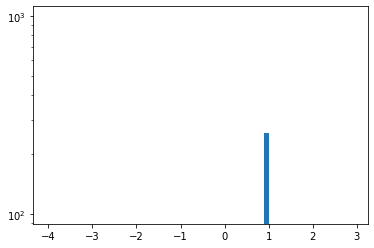

In [104]:
y = np.log10(lofar_sed_en1['SFR_bayes']/(3.8*10**26))
mask = (lofar_sed_en1['Z_BEST']<1) & (lofar_sed_en1['Mass_median']>10.7)
y = y[mask]
bins=np.arange(-4,3,0.1)

plt.hist(y,bins=bins,log=True)
plt.show()

In [105]:
#don't use these as only using magphys seds
'''dust_lum_names = ['Ldust_bayes','LIR','bayes.dust.luminosity_fritz','bayes.dust.luminosity_skirtor']
f_names = ['F_SPIRE_250','F_SPIRE_350','F_SPIRE_500']
sed_name = ['magphys','agnfitter','fritz','skirtor']'''

dust_lum_names = ['Ldust_bayes','LIR']
f_names = ['F_SPIRE_250','F_SPIRE_350','F_SPIRE_500']
sed_name = ['magphys','agnfitter']



catalogues = [lofar_sed_en1,lofar_sed_bootes,lofar_sed_lh]
for n,catalogue in enumerate(catalogues):

    radio_flux = catalogues[n]['Total_flux'].data.data
    redshift = catalogues[n]['Z_BEST'].data.data
    dist = cosmo.luminosity_distance(redshift).to(u.m).value

    alpha = -0.60
    radio_lum = radio_flux*4*np.pi*dist**2 * 1E-26 * (1+redshift)**(-1-alpha)
    radio_lum_col = MaskedColumn(name='radio_luminosity',data=radio_lum)
    catalogues[n].add_column(radio_lum_col)

    for m,name in enumerate(dust_lum_names):
        
        if name not in catalogues[n].columns:
            continue

        if name=='Ldust_bayes':
            dust_lum = []
            for l,num in enumerate(catalogues[n][name]):
                dust_lum.append(num)
            dust_lum = np.array(dust_lum)
            print(dust_lum)
        else:
            dust_lum = catalogues[n][name].data.data

        q = np.log10(dust_lum/3.75E12) - np.log10(radio_lum)
        q_col = MaskedColumn(name='q_'+sed_name[m], data=q)
        catalogues[n].add_column(q_col)
        
    for m,name in enumerate(f_names):
        band = name[-3:]
        q = np.log10(catalogues[n][name].data.data) - np.log10(radio_lum)
        q_col = MaskedColumn(name='q_{}'.format(band), data=q)
        catalogues[n].add_column(q_col)
        
lofar_sed_en1[0]

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Warning: converting a masked element to nan.


[           nan 1.60383880e+38 2.31776924e+38 ...            nan
 9.73010043e+37            nan]
[nan nan nan ... nan nan nan]


/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


[           nan 4.20257071e+38 3.43079786e+39 ... 9.17382824e+37
 5.86173235e+36 1.50480290e+38]


Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,EBV,FUV_flux_corr,FUV_fluxerr_corr,FUV_mag_corr,FUV_magerr_corr,NUV_flux_corr,NUV_fluxerr_corr,NUV_mag_corr,NUV_magerr_corr,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,Z_SOURCE,Z_QUAL,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,2RXS_ID,XMMSL2_ID,ap_to_model_g,ap_to_model_err_g,ap_to_model_r,ap_to_model_err_r,ap_to_model_z,ap_to_model_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,XID+_rerun_mips,XID+_rerun_pacs,XID+_rerun_SPIRE,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,SFR_bayes,chi2,chi2_99_flag,LIR_8_1000_med,LIR_8_1000_p16,LIR_8_1000_p84,LIR_8_1000_ml,LIR,LIR_em,LIR_ep,logL150,goodAF,ln_l,q150,radio_luminosity,q_magphys,q_agnfitter,q_250,q_350,q_500
bytes30,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int6

In [106]:
#Read in the LOFAR and HERschel maps
fname = '../../lofar/deep_fields/ELAIS-N1/data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0]
hdulist.close()

fname = '../../lofar/deep_fields/ELAIS-N1/data/data_release/radio_rms_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs_err = wcs.WCS(radim_header).celestial
radim_err = hdulist[0].data[0][0]
hdulist.close()

  'HZ' -> 'Hz'. [astropy.wcs.wcs]
  'HZ' -> 'Hz'.


In [107]:
#Calculate upper limits on the radio flux from the LOFAR image for the HELP objects
ras = lofar_sed_en1['RA']
decs = lofar_sed_en1['DEC']

x,y = np.round(radim_wcs.wcs_world2pix(ras,decs,0,ra_dec_order=True),0).astype(int)
rad_flux = radim_data[y,x]

x,y = np.round(radim_wcs_err.wcs_world2pix(ras,decs,0,ra_dec_order=True),0).astype(int)
rad_errs = radim_err[y,x]


rad_f_aper_col = Column(name='radio_flux_pixel',data=rad_flux)
rad_ferr_aper_col = Column(name='radio_flux_err_pixel',data=rad_errs)
lofar_sed_en1.add_columns([rad_f_aper_col,rad_ferr_aper_col])

In [108]:
redshift = lofar_sed_en1['Z_BEST']
dist = cosmo.luminosity_distance(redshift).to(u.m).value

alpha = -0.60

radio_lum_aperture = rad_flux*4*np.pi*dist**2 * 1E-26 * (1+redshift)**(-1-alpha)

radio_lum_aper_col = Column(name='radio_luminosity_pixel',data=radio_lum_aperture.data.data)
lofar_sed_en1.add_columns([radio_lum_aper_col])

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [109]:
ldust = lofar_sed_en1['Ldust_bayes']

q_pixel = np.log10(ldust/3.75E12) - np.log10(radio_lum_aperture)

q_pixel_col = MaskedColumn(name='q_pixel',data=q_pixel,fill_value=np.nan)

lofar_sed_en1.add_columns([q_pixel_col])

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


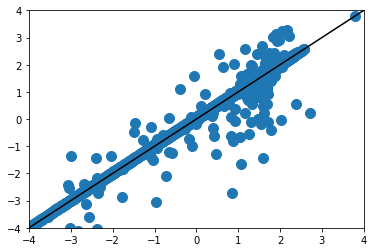

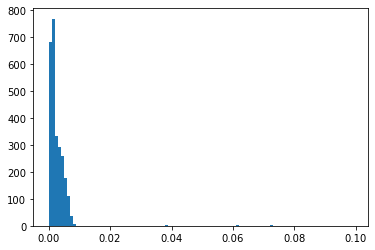

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


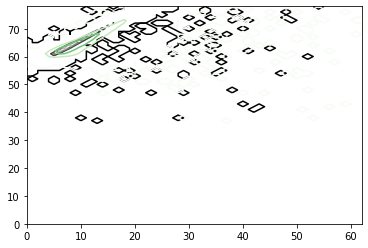

In [110]:
x = lofar_sed_en1['q150']
y = lofar_sed_en1['q_agnfitter']
plt.scatter(x,y,s=100)
plt.plot([-4,4],[-4,4],c='black')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.show()

plt.hist(x-y,bins=np.arange(0.0,0.1,0.001))
plt.show()

binsx= np.arange(-4.2,-1,0.05)
binsy = np.arange(-7,-3,0.05)
x = np.log10(lofar_sed_en1['Peak_flux'])
y = np.log10(lofar_sed_en1['radio_flux_pixel'])
data,_,_ = np.histogram2d(y,x,bins=[binsy,binsx])
plt.contour(data,3,cmap='gray')
x = np.log10(lofar_sed_en1['Total_flux'])
y = np.log10(lofar_sed_en1['radio_flux_pixel'])
data,_,_ = np.histogram2d(y,x,bins=[binsy,binsx])
plt.contour(data,3,cmap='Greens')
plt.show()

KeyError: 'q_fritz'

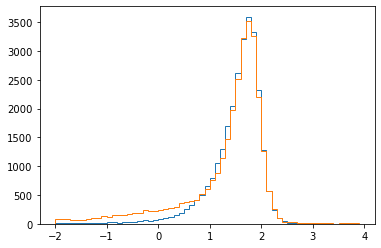

In [18]:

bins = np.arange(-2,4,0.1)
y = lofar_sed_en1['q_magphys']
plt.hist(y,bins=bins,histtype='step',label='magphys')

y = lofar_sed_en1['q_agnfitter']
plt.hist(y,bins=bins,histtype='step',label='agnfitter')

y = lofar_sed_en1['q_fritz']
plt.hist(y,bins=bins,histtype='step',label='fritz')

y = lofar_sed_en1['q_skirtor']
plt.hist(y,bins=bins,histtype='step',label='skirtor')

plt.legend()
plt.show()

In [25]:
#calculate k corrections for every source at 250, 350 and 500um
emitted_f_250 = []
measured_f_250 = []
emitted_f_350 = []
measured_f_350 = []
emitted_f_500 = []
measured_f_500 = []
redshifts = lofar_sed_en1['Z_BEST']
for n,z in enumerate(redshifts):
    if type(z)==np.float64:()
    elif z.mask==True:
        z = np.nan
        
    L_250 = np.interp(spire_250[0],m82[0],m82[1])*spire_250[1]
    tot_250 = np.trapz(spire_250[0],L_250)#*((spire_250[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_250 = tot_250/(4*np.pi*dist*dist)
    emitted_f_250.append(tot_250)
    
    L_250 = np.interp(spire_250[0],m82[0]*(1+z),m82[1])*spire_250[1]
    tot_250 = np.trapz(spire_250[0],L_250)#*((spire_250[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_250 = tot_250/(4*np.pi*dist*dist)
    measured_f_250.append(tot_250)

    L_350 = np.interp(spire_350[0],m82[0],m82[1])*spire_350[1]
    tot_350 = np.trapz(spire_350[0],L_350)#*((spire_350[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_350 = tot_350/(4*np.pi*dist*dist)
    emitted_f_350.append(tot_350)
    
    L_350 = np.interp(spire_350[0],m82[0]*(1+z),m82[1])*spire_350[1]
    tot_350 = np.trapz(spire_350[0],L_350)#*((spire_350[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_350 = tot_350/(4*np.pi*dist*dist)
    measured_f_350.append(tot_350)

    L_500 = np.interp(spire_500[0],m82[0],m82[1])*spire_500[1]
    tot_500 = np.trapz(spire_500[0],L_500)#*((spire_500[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_500 = tot_500/(4*np.pi*dist*dist)
    emitted_f_500.append(tot_500)
    
    L_500 = np.interp(spire_500[0],m82[0]*(1+z),m82[1])*spire_500[1]
    tot_500 = np.trapz(spire_500[0],L_500)#*((spire_500[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_500 = tot_500/(4*np.pi*dist*dist)
    measured_f_500.append(tot_500)
    
emitted_f_250 = np.array(emitted_f_250)
measured_f_250 = np.array(measured_f_250)
k_factor_250 = emitted_f_250/measured_f_250
col_k_250 = MaskedColumn(name='kcorr_250',data=k_factor_250,fill_value=np.nan)

emitted_f_350 = np.array(emitted_f_350)
measured_f_350 = np.array(measured_f_350)
k_factor_350 = emitted_f_350/measured_f_350
col_k_350 = MaskedColumn(name='kcorr_350',data=k_factor_350,fill_value=np.nan)

emitted_f_500 = np.array(emitted_f_500)
measured_f_500 = np.array(measured_f_500)
k_factor_500 = emitted_f_500/measured_f_500
col_k_500 = MaskedColumn(name='kcorr_500',data=k_factor_500,fill_value=np.nan)

lofar_sed_en1.add_columns([col_k_250,col_k_350,col_k_500])

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in double_scalars
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in double_scalars
/its/home/im281/.conda/envs/herschelhelp_v2/li

In [111]:
#Finally add the AGN classifications 
#create a AGN mask that can be applied to the detected sample table
agn_table = Table.read('../../lofar/deep_fields/ELAIS-N1/data/data_release/AGNclasses_ElaisN1_v1.fits')

lofar_sed_en1 = join(lofar_sed_en1,agn_table,keys='Source_Name')
print(len(lofar_sed_en1))

agn_table = Table.read('../../lofar/deep_fields/Bootes/data/data_release/AGNclasses_Bootes_v1.fits')

lofar_sed_bootes = join(lofar_sed_bootes,agn_table,keys='Source_Name')
print(len(lofar_sed_bootes))

agn_table = Table.read('../../lofar/deep_fields/Lockman/data/data_release/AGNclasses_Lockman_v1.fits')

lofar_sed_lh = join(lofar_sed_lh,agn_table,keys='Source_Name')
print(len(lofar_sed_lh))


31610
19166


31161


In [112]:
#write the tables

with serialize_method_as(lofar_sed_en1, None):
            registry.write(lofar_sed_en1,'data/lofar_sed_en1.fits',format='fits',overwrite=True)
        
with serialize_method_as(lofar_sed_bootes, None):
            registry.write(lofar_sed_bootes,'data/lofar_sed_bootes.fits',format='fits',overwrite=True)
        
with serialize_method_as(lofar_sed_lh, None):
            registry.write(lofar_sed_lh,'data/lofar_sed_lh.fits',format='fits',overwrite=True)

compare fluxes against Calistro Rivera bootes data

In [22]:
rivera_data = Table.read('../../lofar/deep_fields/Bootes/data/CR17_LOFARpaper_alldata.fits')
rivera_data[0]

ras = rivera_data['RA']
decs = rivera_data['DEC']
rivera_coords = SkyCoord(ra=ras*u.degree,dec=decs*u.degree)

ras = lofar_bootes['RA']
decs = lofar_bootes['DEC']
lofar_coords = SkyCoord(ra=ras*u.degree,dec=decs*u.degree)

idx,d2d,_ = rivera_coords.match_to_catalog_sky(lofar_coords)

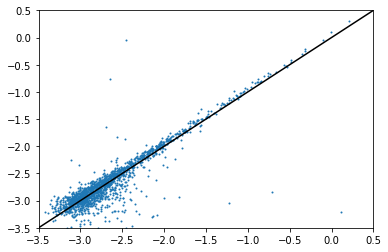

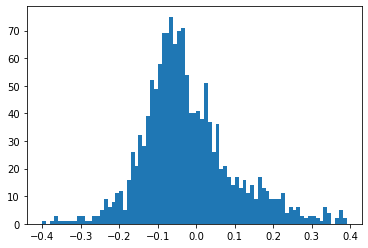

In [23]:
x = np.log10(rivera_data['LOFARtotflux'])
y = np.log10(lofar_bootes['Total_flux'][idx])
plt.scatter(x,y,s=1)
plt.plot([-3.5,0.5],[-3.5,0.5],c='black')
plt.xlim(-3.5,0.5)
plt.ylim(-3.5,0.5)
plt.show()

bins=np.arange(-0.4,0.4,0.01)
plt.hist(x-y,bins=bins)
plt.show()

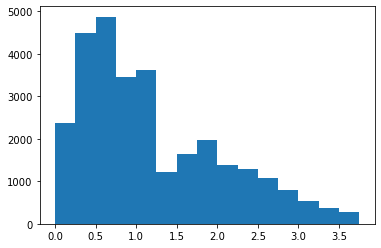

In [24]:
#Look at redshift distribution
bins=np.arange(0,4,0.25)
y = lofar_sed_en1['Z_BEST']
plt.hist(y,bins=bins)
plt.show()

## Create catalogues for the non detection in the radio

This section needs to be run once for each field and change the input files each time as well

In [113]:
#EN1
stellar_mass_cat = Table.read('../../lofar/deep_fields/ELAIS-N1/data/EN1_opt_spitzer_merged_vac_opt3as_irac4as_all_hpx_masses_public.fits')

#Bootes
#stellar_mass_cat = Table.read('../../lofar/deep_fields/ELAIS-N1/data/Bootes_opt_spitzer_merged_vac_opt3as_irac4as_all_hpx_masses_public.fits')

#Lockman
#stellar_mass_cat = Table.read('../../lofar/deep_fields/ELAIS-N1/data/LH_opt_spitzer_merged_vac_opt3as_irac4as_all_hpx_masses_public.fits')

stellar_mass_cat[0]

ID,ID_OPTICAL,ID_SPITZER,RA,DEC,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,FLAG_OVERLAP,FLAG_CLEAN,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,,deg,deg,,deg,deg,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,solMass,solMass,solMass,solMass / yr,solMass / yr,solMass / yr,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int64,int32,int32,float64,float64,bytes27,float64,float64,float32,float32,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bool,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,bytes6,int64,float64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,2,--,242.80436433930626,53.15494170147539,N/A,nan,nan,0.010596914,0.019272702,4,1,1.702929,0.14692508,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,47.798546,2.238821,41.100815,2.6025941,37.71148,10.344152,80.516754,10.564117,nan,nan,nan,nan,nan,nan,nan,nan,True,nan,nan,nan,nan,nan,nan,nan,nan,n

In [114]:
magphys_all_en1 = Table.read('../../lofar/deep_fields/ELAIS-N1/data/magphys/ELAIS_opt.fits')
magphys_all_en1.rename_column('galaxy_id','ID')

print(len(magphys_all_en1))

magphys_cols = ['galaxy_id','Mstar_best','Mstar_sigma','Mstar_bayes','Mstar_03','Mstar_16','Mstar_50','Mstar_84','Mstar_98','Ldust_best','Ldust_sigma','Ldust_bayes','Ldust_03','Ldust_16','Ldust_50','Ldust_84','Ldust_98','chi2','chi2_99_flag']

mask = get_good_sed_fit_mask(magphys_all_en1,'magphys')
magphys_all_en1 = magphys_all_en1[mask]
for m,name in enumerate(magphys_cols):
    if m==0:
        continue
    if 'chi' in name:
        continue
    magphys_all_en1[name] = magphys_all_en1[name]*3.8*10**26
    magphys_all_en1[name] = magphys_all_en1[name].astype(float)

print(len(magphys_all_en1))
magphys_all_en1['ID'] = magphys_all_en1['ID'].astype('int64')
magphys_all_en1[1]

183399
165114


ID,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98
int64,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1645503,0.3414,2.467,0,0.612,0.054,0.62027395,0.513,0.563,0.614,0.671,0.725,0.635,0.097,0.61814207,0.438,0.521,0.623,0.715,0.789,0.167,0.2,0.36557588,0.131,0.17,0.328,0.57,0.744,4.96,1.1875,2.4688153,0.897,1.342,2.162,3.717,4.957,7.77e-11,2.089804e-11,7.282983e-11,3.801894e-11,5.370318e-11,6.76083e-11,9.549926e-11,1.3335215e-10,1.10693998592e+37,2.0386648064000002e+36,1.00770635776e+37,6.6036432896e+36,7.939325132800001e+36,1.02278324224e+37,1.2016654745600002e+37,1.34829080576e+37,1.4633798860800001e+37,3.1824427008e+36,1.20726994944e+37,7.0759309312e+36,9.1155644416e+36,1.1475816448e+37,1.5480450252800001e+37,1.9942683443200002e+37,22.1,2.975,20.18024,15.463,17.213,20.263,23.163,24.638,38.9,10.2,44.945644,30.688,34.738,44.938,55.138,59.288,0.561,0.111,0.47895503,0.282,0.368,0.478,0.59,0.679,0.099,0.0435,0.13505289,0.065,0.093,0.131,0.18,0.233,0.158,0.0565,0.19532722,0.1,0.139,0.19,0.252,0.327,0.182,0.1135,0.19026528,0.024,0.077,0.18,0.304,0.414,0.828,0.1725,0.74072635,0.442,0.567,0.717,0.912,1.067,35740000.0,33266482.0,53728300.0,11668096.0,21978598.0,42364296.0,88511560.0,152054750.0,2.264,0.419804,1.8850276,1.0764652,1.4354894,1.8071741,2.2750974,3.1045597


In [115]:
#join with Kens catalogue to get stellar masses for these sources
magphys_stellar_mass_en1 = join(magphys_all_en1,stellar_mass_cat,keys='ID',join_type='inner')
magphys_stellar_mass_en1[0]

ID,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98,ID_OPTICAL,ID_SPITZER,RA,DEC,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,FLAG_OVERLAP,FLAG_CLEAN,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,deg,deg,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,solMass,solMass,solMass,solMass / yr,solMass / yr,solMass / yr,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int64,float32,float32,int16,float32,float32,float32,float32,float32,float32,flo

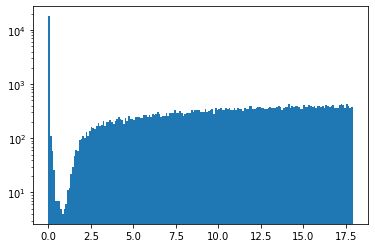

58.90268815460943% of LOFAR sources have a magphys source within 1.0 arcseconds
146949


ID,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98,ID_OPTICAL,ID_SPITZER,RA,DEC,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,FLAG_OVERLAP,FLAG_CLEAN,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,deg,deg,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,solMass,solMass,solMass,solMass / yr,solMass / yr,solMass / yr,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag
int64,float32,float32,int16,float32,float32,float32,float32,float32,float32,flo

In [116]:
#remove sources that are already detected in the LOFAR catalogue

ras = magphys_stellar_mass_en1['RA']
decs = magphys_stellar_mass_en1['DEC']

high_mass_coords = SkyCoord(ra=ras,dec=decs)

mask = ~np.isnan(lofar_sed_en1['optRA'])
ras = lofar_sed_en1['optRA'][mask]
decs = lofar_sed_en1['optDec'][mask]
help_ldust_coords = SkyCoord(ra=ras*u.degree,dec=decs*u.degree)

idx,d2d,_ = high_mass_coords.match_to_catalog_sky(help_ldust_coords)

d2d = d2d.value*3600
plt.hist(d2d,bins=np.arange(0,18,0.1),log=True)
plt.show()

sep_dist = 1.0
print('{}% of LOFAR sources have a magphys source within {} arcseconds'.format(np.sum(d2d<sep_dist)/np.sum(mask)*100,sep_dist))

mask = d2d<sep_dist
magphys_stellar_mass_en1 = magphys_stellar_mass_en1[~mask]

print(len(magphys_stellar_mass_en1))
magphys_stellar_mass_en1[0]

In [117]:
#Read in the LOFAR and HERschel maps
fname = '../../lofar/deep_fields/ELAIS-N1/data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0]
hdulist.close()

fname = '../../lofar/deep_fields/ELAIS-N1/data/data_release/radio_rms_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs_err = wcs.WCS(radim_header).celestial
radim_err = hdulist[0].data[0][0]
hdulist.close()

  'HZ' -> 'Hz'. [astropy.wcs.wcs]
  'HZ' -> 'Hz'.


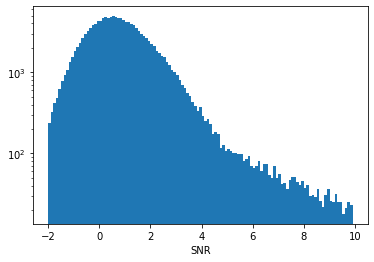

In [118]:
#Calculate upper limits on the radio flux from the LOFAR image for the HELP objects
ras = magphys_stellar_mass_en1['RA']
decs = magphys_stellar_mass_en1['DEC']

x,y = np.round(radim_wcs.wcs_world2pix(ras,decs,1,ra_dec_order=True),0).astype(int)
rad_flux = radim_data[y,x]

x,y = np.round(radim_wcs_err.wcs_world2pix(ras,decs,1,ra_dec_order=True),0).astype(int)
rad_errs = radim_err[y,x]

rad_upper_lims = rad_errs*5

SNR = rad_flux/rad_errs
bins = np.arange(-2,10,0.1)
plt.hist(SNR,bins=bins,log=True)

plt.xlabel('SNR')
plt.show()

rad_f_aper_col = Column(name='radio_flux_pixel',data=rad_flux)
rad_f_lim_col = Column(name='radio_flux_limit',data=rad_upper_lims)
magphys_stellar_mass_en1.add_columns([rad_f_aper_col,rad_f_lim_col])

In [119]:
redshift = magphys_stellar_mass_en1['Z_BEST']
dist = cosmo.luminosity_distance(redshift).to(u.m).value

alpha = -0.60
radio_lum_upper = rad_upper_lims*4*np.pi*dist**2 * 1E-26 * (1+redshift)**(-1-alpha)
radio_lum_aperture = rad_flux*4*np.pi*dist**2 * 1E-26 * (1+redshift)**(-1-alpha)

radio_lum_aper_col = Column(name='radio_luminosity_pixel',data=radio_lum_aperture)
radio_lum_upper_col = Column(name='radio_luminosity_limit',data=radio_lum_upper)
magphys_stellar_mass_en1.add_columns([radio_lum_aper_col,radio_lum_upper_col])

In [120]:
ldust = magphys_stellar_mass_en1['Ldust_bayes']

q_lim = np.log10(ldust/3.75E12) - np.log10(radio_lum_upper)
q_pixel = np.log10(ldust/3.75E12) - np.log10(radio_lum_aperture)
q_lim_250 = np.log10(magphys_stellar_mass_en1['F_SPIRE_250']) - np.log10(radio_lum_upper)
q_lim_350 = np.log10(magphys_stellar_mass_en1['F_SPIRE_350']) - np.log10(radio_lum_upper)
q_lim_500 = np.log10(magphys_stellar_mass_en1['F_SPIRE_500']) - np.log10(radio_lum_upper)

q_pixel_col = MaskedColumn(name='q_pixel',data=q_pixel,fill_value=np.nan)
q_lim_col = MaskedColumn(name='q_lim',data=q_lim,fill_value=np.nan)
q_250_col = MaskedColumn(name='q_250_lim',data=q_lim_250,fill_value=np.nan)
q_350_col = MaskedColumn(name='q_350_lim',data=q_lim_350,fill_value=np.nan)
q_500_col = MaskedColumn(name='q_500_lim',data=q_lim_500,fill_value=np.nan)


magphys_stellar_mass_en1.add_columns([q_pixel_col,q_lim_col,q_250_col,q_350_col,q_500_col])

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_lau

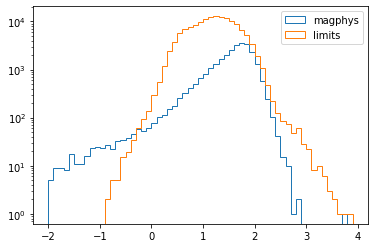

In [121]:
bins = np.arange(-2,4,0.1)
y = lofar_sed_en1['q_magphys']
plt.hist(y,bins=bins,histtype='step',label='magphys',log=True)

plt.hist(q_lim,bins=bins,histtype='step',label='limits',log=True)
plt.legend()
plt.show()

In [122]:
magphys_stellar_mass_en1[0]

ID,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98,ID_OPTICAL,ID_SPITZER,RA,DEC,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,FLAG_OVERLAP,FLAG_CLEAN,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,radio_flux_pixel,radio_flux_limit,radio_luminosity_pixel,radio_luminosity_limit,q_pixel,q_lim,q_250_lim,q_350_lim,q_500_lim
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,deg,deg,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,solMass,solMass,solMass,solMass / yr,solMass / yr,solMass / yr,,mag,mag,mag

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


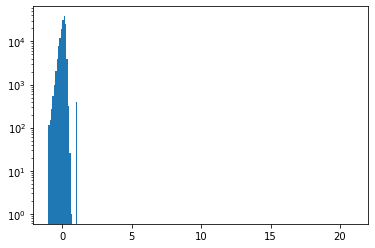

In [123]:
y = np.log10(magphys_stellar_mass_en1['q_lim'])
bins = np.arange(-1,21,0.1)
plt.hist(y,bins=bins,log=True)
plt.show()

In [39]:
#calculate k corrections for every source at 250, 350 and 500um
emitted_f_250 = []
measured_f_250 = []
emitted_f_350 = []
measured_f_350 = []
emitted_f_500 = []
measured_f_500 = []
redshifts = magphys_stellar_mass_en1['Z_BEST']
for n,z in enumerate(redshifts):
    L_250 = np.interp(spire_250[0],m82[0],m82[1])*spire_250[1]
    tot_250 = np.trapz(spire_250[0],L_250)#*((spire_250[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_250 = tot_250/(4*np.pi*dist*dist)
    emitted_f_250.append(tot_250)
    
    L_250 = np.interp(spire_250[0],m82[0]*(1+z),m82[1])*spire_250[1]
    tot_250 = np.trapz(spire_250[0],L_250)#*((spire_250[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_250 = tot_250/(4*np.pi*dist*dist)
    measured_f_250.append(tot_250)

    L_350 = np.interp(spire_350[0],m82[0],m82[1])*spire_350[1]
    tot_350 = np.trapz(spire_350[0],L_350)#*((spire_350[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_350 = tot_350/(4*np.pi*dist*dist)
    emitted_f_350.append(tot_350)
    
    L_350 = np.interp(spire_350[0],m82[0]*(1+z),m82[1])*spire_350[1]
    tot_350 = np.trapz(spire_350[0],L_350)#*((spire_350[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_350 = tot_350/(4*np.pi*dist*dist)
    measured_f_350.append(tot_350)

    L_500 = np.interp(spire_500[0],m82[0],m82[1])*spire_500[1]
    tot_500 = np.trapz(spire_500[0],L_500)#*((spire_500[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_500 = tot_500/(4*np.pi*dist*dist)
    emitted_f_500.append(tot_500)
    
    L_500 = np.interp(spire_500[0],m82[0]*(1+z),m82[1])*spire_500[1]
    tot_500 = np.trapz(spire_500[0],L_500)#*((spire_500[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_500 = tot_500/(4*np.pi*dist*dist)
    measured_f_500.append(tot_500)
    
emitted_f_250 = np.array(emitted_f_250)
measured_f_250 = np.array(measured_f_250)
k_factor_250 = emitted_f_250/measured_f_250
col_k_250 = MaskedColumn(name='kcorr_250',data=k_factor_250,fill_value=np.nan)

emitted_f_350 = np.array(emitted_f_350)
measured_f_350 = np.array(measured_f_350)
k_factor_350 = emitted_f_350/measured_f_350
col_k_350 = MaskedColumn(name='kcorr_350',data=k_factor_350,fill_value=np.nan)

emitted_f_500 = np.array(emitted_f_500)
measured_f_500 = np.array(measured_f_500)
k_factor_500 = emitted_f_500/measured_f_500
col_k_500 = MaskedColumn(name='kcorr_500',data=k_factor_500,fill_value=np.nan)

magphys_stellar_mass_en1.add_columns([col_k_250,col_k_350,col_k_500])

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in double_scalars
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars
/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars
/its/home/im281/.conda/envs/

In [124]:
with serialize_method_as(magphys_stellar_mass_en1, None):
            registry.write(magphys_stellar_mass_en1,'data/magphys_mass_radio_limits_en1.fits',format='fits',overwrite=True)

In [ ]:
f = open('/lustre/scratch/astro/im281/cigalon/cigale-cigalon/database_builder/filters/spire_250.dat')
wave = []
transmission = []
for line in f:
    
    line = line.split()
    try:
        float(line[0])
    except:
        continue
    wave.append(float(line[0]))
    transmission.append(float(line[1]))
wave = np.array(wave)/1E4
spire_250 = [wave,np.array(transmission)]

f = open('/lustre/scratch/astro/im281/cigalon/cigale-cigalon/database_builder/filters/spire_350.dat')
wave = []
transmission = []
for line in f:
    
    line = line.split()
    try:
        float(line[0])
    except:
        continue
    wave.append(float(line[0]))
    transmission.append(float(line[1]))
wave = np.array(wave)/1E4
spire_350 = [wave,np.array(transmission)]

f = open('/lustre/scratch/astro/im281/cigalon/cigale-cigalon/database_builder/filters/spire_500.dat')
wave = []
transmission = []
for line in f:
    
    line = line.split()
    try:
        float(line[0])
    except:
        continue
    wave.append(float(line[0]))
    transmission.append(float(line[1]))
wave = np.array(wave)/1E4
spire_500 = [wave,np.array(transmission)]

f = open('data/templates/M82_template_norm.sed')
wave = []
sed = []
for line in f:
    line = line.split()
    try:
        float(line[0])
    except:
        continue
    wave.append(float(line[0]))
    sed.append(float(line[1]))
wave = np.array(wave)/1E4
m82 = [wave,np.array(sed)]

In [ ]:
z = 0
x = np.log10(wave*(1+z))
y = np.log10(sed)
plt.plot(x,y)

x = np.log10(spire_250[0])
y = np.log10(spire_250[1])
plt.plot(x,y)
x = np.log10(spire_350[0])
y = np.log10(spire_350[1])
plt.plot(x,y)
x = np.log10(spire_500[0])
y = np.log10(spire_500[1])
plt.plot(x,y)
plt.show()

In [ ]:
for n,z in enumerate(redshifts):
    L_500 = np.interp(spire_500[0],m82[0],m82[1])*spire_500[1]
    tot_500 = np.trapz(spire_500[0],L_500)#*((spire_500[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_500 = tot_500/(4*np.pi*dist*dist)
    emitted_f_500.append(tot_500)
    
    L_500 = np.interp(spire_500[0],m82[0]*(1+z),m82[1])*spire_500[1]
    tot_500 = np.trapz(spire_500[0],L_500)#*((spire_500[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_500 = tot_500/(4*np.pi*dist*dist)
    measured_f_500.append(tot_500)
    
emitted_f_500 = np.array(emitted_f_500)
measured_f_500 = np.array(measured_f_500)
k_factor_500 = emitted_f_500/measured_f_500

In [ ]:
emitted_f_250 = []
measured_f_250 = []
emitted_f_350 = []
measured_f_350 = []
emitted_f_500 = []
measured_f_500 = []
redshifts = np.arange(0,2,0.001)
for n,z in enumerate(redshifts):
    L_250 = np.interp(spire_250[0],m82[0],m82[1])*spire_250[1]
    tot_250 = np.trapz(spire_250[0],L_250)#*((spire_250[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_250 = tot_250/(4*np.pi*dist*dist)
    emitted_f_250.append(tot_250)
    
    L_250 = np.interp(spire_250[0],m82[0]*(1+z),m82[1])*spire_250[1]
    tot_250 = np.trapz(spire_250[0],L_250)#*((spire_250[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_250 = tot_250/(4*np.pi*dist*dist)
    measured_f_250.append(tot_250)

    L_350 = np.interp(spire_350[0],m82[0],m82[1])*spire_350[1]
    tot_350 = np.trapz(spire_350[0],L_350)#*((spire_350[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_350 = tot_350/(4*np.pi*dist*dist)
    emitted_f_350.append(tot_350)
    
    L_350 = np.interp(spire_350[0],m82[0]*(1+z),m82[1])*spire_350[1]
    tot_350 = np.trapz(spire_350[0],L_350)#*((spire_350[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_350 = tot_350/(4*np.pi*dist*dist)
    measured_f_350.append(tot_350)

    L_500 = np.interp(spire_500[0],m82[0],m82[1])*spire_500[1]
    tot_500 = np.trapz(spire_500[0],L_500)#*((spire_500[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_500 = tot_500/(4*np.pi*dist*dist)
    emitted_f_500.append(tot_500)
    
    L_500 = np.interp(spire_500[0],m82[0]*(1+z),m82[1])*spire_500[1]
    tot_500 = np.trapz(spire_500[0],L_500)#*((spire_500[0])**2/3E8))
    dist = cosmo.luminosity_distance(z).to(u.m).value
    tot_500 = tot_500/(4*np.pi*dist*dist)
    measured_f_500.append(tot_500)
    
emitted_f_250 = np.array(emitted_f_250)
measured_f_250 = np.array(measured_f_250)
k_factor_250 = emitted_f_250/measured_f_250

emitted_f_350 = np.array(emitted_f_350)
measured_f_350 = np.array(measured_f_350)
k_factor_350 = emitted_f_350/measured_f_350

emitted_f_500 = np.array(emitted_f_500)
measured_f_500 = np.array(measured_f_500)
k_factor_500 = emitted_f_500/measured_f_500

plt.plot(redshifts+1,k_factor_250,label='250')
plt.plot(redshifts+1,k_factor_350,label='350')
plt.plot(redshifts+1,k_factor_500,label='500')
plt.legend()
plt.show()

In [ ]:
measured_f

In [ ]:
emitted_f

In [ ]:
k_factor